## Mark 

Author: Nuo Yi

Date: 2021/11/15

This code solves out the equilibrium of the tax-education subsidy model written up in the Section 2.2 of file "**F-HACT Education Subsidy.pdf**", which is my paper draft. 

If go to the file "**F-HACT Education Subsidy.pdf**" directly, please click here: [Github:Public-Education-Subsidy paper](https://github.com/yinuonino/Public-Education-Subsidy/blob/main/F-HACT%20Education%20Subsidy.pdf)






In [1]:
%matplotlib inline
import numpy as np
import math
import matplotlib.pyplot as plt
plt.rc('text', usetex=True)
from scipy import sparse
from scipy.sparse.linalg import spsolve
from scipy.optimize import root,fsolve
from scipy.integrate import odeint
from time import time

class Household(object):
    ### generate an economy case
    def __init__(self,
                 rho=0.05,       # time discount factor 
                 sigma = 0.56,  # S.D. from literature
                 eta=1.15, # RRA from literature
                 tau=0.128,  # linear tax rate from literature
                 w_vals=[5],     # exogenous income states 
                 trans=[0], # no transation
                 h_min=1e-10,    # minimum human capital/income amount, tiny value close to zero
                 h_max=3000,        # maximum human capital/income amount 
                 I=1000,    # I = number of asset grid points
                 ga1 = 0.30, 
                 ga2 = 0.20,
                 eps1 = 0.9, # education elasticity
                 eps2 = 0.5,
                 discount = 0.06, # human capital disount rate from literature
                 step_length = 1000, # step length
                 pi = 0.1, # constant public education
                 zeta= 0.5, # subsidy scheme
                 beta=1,
                 num = 3): # points dropped from lower boundary

        ### Initialize values, and set up grids
        self.rho,self.sigma,self.eta,self.tau = rho,sigma,eta,tau
        self.ga1,self.ga2 = ga1,ga2
        self.eps1,self.eps2 = eps1,eps2
        self.pi,self.zeta,self.beta = pi,zeta,beta
        self.h_min,self.h_max,self.I = h_min, h_max,I
        self.dh = (self.h_max-self.h_min)/(self.I-1) 
        self.w_vals = np.asarray(w_vals)
        self.trans = trans
        self.h_vals = np.linspace(self.h_min,self.h_max,self.I)
        self.subsidy_vals = self.beta*self.h_vals**(-self.zeta)
        self.T = self.pi+self.subsidy_vals
        self.discount = discount
        self.step_length = step_length 
        self.xi = (1-self.eta-self.eps1)*self.sigma**2*self.h_max/2
        self.num = num
        self.posi_h_vals = self.h_vals[self.num:] 
        #posi_ variables refer to those dropping some points at lower boundary
        self.posi_subsidy_vals = self.subsidy_vals[self.num:]
        ### Preallocation
        self.v_old = np.zeros((1,self.I)) 
        self.f = np.zeros((1,self.I)) 
        self.dv = np.zeros((1,self.I-1)) # v_f'(h)
        self.cf = np.zeros((1,self.I-1)) # c_f(h)
        self.ef = np.zeros((1,self.I-1))
        self.c0 = np.zeros((1,self.I))
        self.e0 = np.zeros((1,self.I))
        self.ssf = np.zeros((1,self.I))
        self.ssb = np.zeros((1,self.I))
        self.is_forward = np.zeros((1,self.I),'bool') 
        self.is_backward = np.zeros((1,self.I),'bool')
        self.A = np.zeros((self.I,self.I))
        self.h = np.tile(self.h_vals,(1,1)) #1*I matrix
        self.subsidy = np.tile(self.subsidy_vals,(1,1))
        self.w = np.tile(self.w_vals,(self.I,1)).transpose()
        self.h_sq=self.h**2
        self.tic=0 # iterative number   
        ### Initial Guess       
        self.v = (1-self.tau)*self.h/2 # initial consumption
        self.v = self.v**(1-self.eta)/self.rho/(1-self.eta) #initial value CRRA 
        
    def solve_foc(self):
        ### solve non-linear F.O.C.
        for i in range(self.I-1):
            def solve_household_foc(x):
                return x**(-self.eta)-self.dv[0][i]*self.ga1*self.eps1*((1-self.tau)\
                       *self.h[0][i+1]-x)**(self.eps1-1)
            root_foc = root(solve_household_foc,[self.h[0][i+1]**(1/3)])
            # there may be more feasible forms for initial guess
            self.cf[0][i] = fsolve(solve_household_foc,[self.h[0][i+1]**(1/3)])
        return self.cf
   
    def saving_function(self):
        ### saving function
        self.s0 = self.ga1*((1-self.tau)*self.h-self.c0)**self.eps1 \
                  +self.ga2*self.T**self.eps2-self.discount*self.h+self.w
        return self.s0
               
    def utility_function(self):
        ### utility function
        return self.c0**(1-self.eta)/(1-self.eta)
                    
    def solve_bellman(self,crit=1e-6):
        ### solve the HJB equation and get household's policy functions and value function.
        ### compute saving and consumption implied by current guess for value function, using upwind method.
        dist=100.0
        while dist > crit: 
            self.dv = (self.v[:,1:]-self.v[:,:-1])/self.dh 
            ### Initial Guess
            self.c0= (1-self.tau)*self.h/2
            ### solve non-linear F.O.C.
            self.cf = self.solve_foc()    
            ### Computes savings with FD difference and backward difference
            self.ssf[:,:-1] = self.c0[:,:-1]-self.cf 
            self.ssb[:,1:] = self.c0[:,1:]-self.cf 
            self.is_forward = self.ssf>0 
            self.is_backward = self.ssb<0
            ### U.pdate consumption based on forward or backward difference based on direction of drift
            self.c0[:,:-1] += (self.cf-self.c0[:,:-1])*self.is_forward[:,:-1] 
            self.c0[:,1:] += (self.cf-self.c0[:,1:])*self.is_backward[:,1:]
            self.c1=self.c0.copy()
            self.s0 = self.saving_function()     
            self.u0 = self.utility_function()
            ### Matrix System     
            self.A = np.zeros((self.I,self.I)) 
            self.Y = -self.ssf*self.is_forward/self.dh\
                    +self.ssb*self.is_backward/self.dh-(self.sigma/self.dh)**2*self.h_sq 
            self.Y[:,0] = -self.ssf[:,0]*self.is_forward[:,0]/self.dh\
                          -self.ssb[:,0]*self.is_backward[:,0]/self.dh   # Lower Boundary               
            self.Y[:,self.I-1] = self.ssf[:,self.I-1]*self.is_forward[:,self.I-1]/self.dh \
                               + self.ssb[:,self.I-1]*self.is_backward[:,self.I-1]/self.dh\
                               +self.xi/self.dh  # Upper Boundary
            self.Y=self.Y.reshape(self.I) # to_list
            self.A += sparse.spdiags(self.Y,0,self.I,self.I) 
            self.X = -self.ssb*self.is_backward/self.dh+(self.sigma/self.dh)**2*self.h_sq/2
            self.X[:,0] = 0 #lower 
            self.X[:,self.I-1] =-self.ssb[:,self.I-1]*self.is_backward[:,self.I-1]/self.dh\
                                -self.xi/self.dh                          
            self.X = self.X.reshape(self.I)
            self.A += sparse.spdiags(self.X[1:],-1,self.I,self.I)                      
            self.Z = self.ssf*self.is_forward/self.dh+(self.sigma/self.dh)**2*self.h_sq/2
            self.Z[:,0] = self.ssf[:,0]*self.is_forward[:,0]/self.dh\
                        + self.ssb[:,0]*self.is_backward[:,0]/self.dh
            self.Z[:,self.I-1] = 0 
            self.Z = self.Z.reshape(self.I)                            
            self.A += sparse.spdiags(np.hstack((0,self.Z)),1,self.I,self.I)
            ### Solve the system of linear equations corresponding to implicit finite difference scheme
            self.B = sparse.eye(self.I)*(1/self.step_length+self.rho)- self.A
            self.b = self.u0.reshape(self.I,1)+self.v.reshape(self.I,1)/self.step_length 
            self.v_old = self.v.copy() 
            self.v = spsolve(self.B,self.b).reshape(1,self.I)
            ### Compute convergence metric and stop if it satisfies the convergence criterion
            dist = np.amax(np.absolute(self.v_old-self.v).reshape(self.I))
            self.tic += 1
        self.s0 = self.saving_function()  
        self.e0 = (1-self.tau)*self.h-self.c0
#         self.v = self.utility_function()
        return self.s0,self.v,self.c0,self.e0
    
    def drop_negative_points(self):
        ### drop some points from lower boundary.
        self.s0_vals = self.s0.T # saving matrix
        self.c0_vals = self.c0.T 
        self.v_vals = self.v.T
        self.e0_vals = self.e0.T
        self.posi_s0_vals = self.s0_vals[self.num:]
        self.posi_c0_vals = self.c0_vals[self.num:]
        self.posi_v_vals = self.v_vals[self.num:]
        self.posi_e0_vals = self.e0_vals[self.num:]
        return self.posi_s0_vals, self.posi_c0_vals, self.posi_v_vals,self.posi_e0_vals
    
    def set_reference_point(self,h0):
        ### set the reference point for solving density from iterative method.
        sign = np.zeros((self.I,1)) # any human capital value can work as reference point.
        lst = list()
        for i in range(self.I):
            if self.h[0][i]<h0:
                sign[i] = -1
            else:
                sign[i] = 1
        for i in sign:
            lst.append(i)
        position_h0 = lst.index([h0]) #h_0 = 1
        print('h value at reference point=',h0)
        print('grid position of h0=',position_h0)
        return position_h0
    
    
    def solve_kfe_iterative(self):
    ### solve the human capital/income distribution from KF equation through iterative method.
        self.solve_bellman() 
        self.drop_negative_points()
        position_h0 = self.set_reference_point(1)
        ### Generate the  human capital distribution f(h)
        self.f = np.zeros((1,self.I))
        self.f[0][position_h0] = 0.1 # arbitary constant 
        for i in range(position_h0,self.I-1):
            self.f[0][i+1] = self.f[0][i]\
              +(-2)*(1/self.h_vals[i]-self.s0[0][i]/(self.sigma*self.h[0][i])**2)*self.f[0][i]*self.dh
        for i in range(position_h0,0,-1):
            self.f[0][i-1] = self.f[0][i]\
               +2*(1/self.h_vals[i]-self.s0[0][i]/(self.sigma*self.h[0][i])**2)*self.f[0][i]*self.dh
        trapezoid_f = np.zeros((self.I,1)) 
        for i in range(1,self.I):
            trapezoid_f[i] = (self.f[0][i-1]+self.f[0][i])*self.dh/2
        self.f = self.f*self.dh/np.sum(trapezoid_f)   
        self.posi_f = self.f[:,self.num:]
        trapezoid_posi_f = np.zeros((self.I-self.num,1)) 
        for i in range(1,self.I-self.num):
            trapezoid_posi_f[i] = (self.posi_f[0][i-1]+self.posi_f[0][i])*self.dh/2
        self.posi_f = self.posi_f*self.dh/np.sum(trapezoid_posi_f) #normalizing density
        ### Aggregation
        hf  = np.zeros((self.I,1))
        vf = np.zeros((self.I,1))
        s0f = np.zeros((self.I,1))
        c0f = np.zeros((self.I,1))
        subf = np.zeros((self.I,1))
        posi_hf  = np.zeros((self.I-self.num,1))
        posi_vf = np.zeros((self.I-self.num,1))
        posi_s0f = np.zeros((self.I-self.num,1))
        posi_c0f = np.zeros((self.I-self.num,1))
        posi_subf = np.zeros((self.I-self.num,1))
        trapezoid_posi_hf = np.zeros((self.I-self.num,1))
        trapezoid_posi_vf = np.zeros((self.I-self.num,1))
        trapezoid_posi_s0f = np.zeros((self.I-self.num,1))
        trapezoid_posi_c0f= np.zeros((self.I-self.num,1))
        trapezoid_posi_subf= np.zeros((self.I-self.num,1))
        for i in range(1,self.I): 
            hf[i] = self.f[0][i]*self.h_vals[i]*self.dh 
            vf[i] = self.f[0][i]*self.v_vals[i]*self.dh 
            s0f[i] = self.f[0][i]*self.s0_vals[i]*self.dh 
            c0f[i] = self.f[0][i]*self.c0_vals[i]*self.dh  
            subf[i] = self.f[0][i]*self.subsidy_vals[i]*self.dh  
        for i in range(1,self.I-self.num): 
            posi_hf[i] = self.posi_f[0][i]*self.posi_h_vals[i] 
            posi_vf[i] = self.posi_f[0][i]*self.posi_v_vals[i] 
            posi_s0f[i] = self.posi_f[0][i]*self.posi_s0_vals[i] 
            posi_c0f[i] = self.posi_f[0][i]*self.posi_c0_vals[i]  
            posi_subf[i] = self.posi_f[0][i]*self.posi_subsidy_vals[i]  
        for i in range(1,self.I-self.num):
            trapezoid_posi_hf[i] = (posi_hf[i-1]+posi_hf[i])*self.dh/2
            trapezoid_posi_vf[i] = (posi_vf[i-1]+posi_vf[i])*self.dh/2
            trapezoid_posi_s0f[i] = (posi_s0f[i-1]+posi_s0f[i])*self.dh/2
            trapezoid_posi_c0f[i] = (posi_c0f[i-1]+posi_c0f[i])*self.dh/2
            trapezoid_posi_subf[i] = (posi_subf[i-1]+posi_subf[i])*self.dh/2
    
        self.h_steady, self.posi_h_steady = np.sum(hf),np.sum(posi_hf)
        self.s_steady,self.posi_s_steady = np.sum(s0f),np.sum(posi_s0f)
        self.esubsidy,self.posi_esubsidy = np.sum(subf),np.sum(posi_subf)
        self.beta_new,self.posi_beta_new = (self.h_steady*self.tau-self.pi)/self.esubsidy,\
        (self.posi_h_steady*self.tau-self.pi)/self.posi_esubsidy
        self.welfare_steady,self.posi_welfare_steady = np.sum(vf),np.sum(posi_vf)
        return self.f,self.posi_f
    
    def solve_kfe_moll(self):
    ### solve the human capital/income distribution from KF equation through the algorithm in HACT(2020).
        self.solve_bellman()
        self.drop_negative_points()
        self.A_k = sparse.kron(self.trans,sparse.eye(self.I), format="csr")
        self.Y_k = -self.ssf*self.is_forward/self.dh+self.ssb*self.is_backward/self.dh\
                   -(self.sigma/self.dh)**2*self.h_sq 
        self.Y_k[:,0] = -self.ssf[:,0]*self.is_forward[:,0]/self.dh 
        self.Y_k[:,self.I-1] = self.ssb[:,self.I-1]*self.is_backward[:,self.I-1]/self.dh\
                               -1/2*self.sigma**2*self.h_max**2/(self.dh**2)
        self.Y_k=self.Y_k.reshape(self.I) 
        self.A_k += sparse.spdiags(self.Y_k,0,self.I,self.I)
        self.X_k = -self.ssb*self.is_backward/self.dh+(self.sigma/self.dh)**2*self.h_sq/2
        self.X_k[:,1]=(self.sigma*self.h_vals[1]/self.dh)**2/2
        self.X_k[:,self.I-1]= -self.ssb[:,self.I-1]*self.is_backward[:,self.I-1]/self.dh\
                              +1/2*self.sigma**2*self.h_max**2/(self.dh**2)
        self.X_k=self.X_k.reshape(self.I) 
        self.A_k += sparse.spdiags(self.X_k[1:],-1,self.I,self.I)
        self.Z_k = self.ssf*self.is_forward/self.dh+(self.sigma/self.dh)**2*self.h_sq/2
        self.Z_k=self.Z_k.reshape(self.I)    
        self.A_k += sparse.spdiags(np.hstack((0,self.Z_k)),1,self.I,self.I)        
        self.AT_k = self.A_k.transpose().tocsr()
        # The discretized Kolmogorov Forward equation AT*g=0 is an eigenvalue problem
        # AT is singular because one of the equation is the distribution adding
        # up to 1. Here we solve the eigenvalue problem by setting g(1,1)=0.1
        # and the equation is solved relative to that value.
        # Alternatively, one could use a routine for solving eigenvalue problems.
        self.b_k = np.zeros((self.I,1))
        self.b_k[0] = 0.1
        self.AT_k.data[1:self.AT_k.indptr[1]] = 0
        self.AT_k.data[0] = 1.0
        self.AT_k.indices[0] = 0
        self.AT_k.eliminate_zeros()
        self.f = spsolve(self.AT_k,self.b_k).reshape(1,self.I)

        self.f = self.f/np.sum(self.f) # renormalize f to add up to 1
        self.posi_f = self.f[:,self.num:]
        self.posi_f = self.posi_f/np.sum(self.posi_f)
        ### Aggregation
        hf  = np.zeros((self.I,1))
        vf = np.zeros((self.I,1))
        s0f = np.zeros((self.I,1))
        c0f = np.zeros((self.I,1))
        subf = np.zeros((self.I,1))
        for i in range(0,self.I): 
            hf[i] = self.f[0][i]*self.h_vals[i]*self.dh
            vf[i] = self.f[0][i]*self.v_vals[i]*self.dh
            s0f[i] = self.f[0][i]*self.s0_vals[i]*self.dh
            c0f[i] = self.f[0][i]*self.c0_vals[i]*self.dh
            subf[i] = self.f[0][i]*self.subsidy_vals[i]*self.dh
            
        posi_hf  = np.zeros((self.I-self.num,1))
        posi_vf = np.zeros((self.I-self.num,1))
        posi_s0f = np.zeros((self.I-self.num,1))
        posi_c0f = np.zeros((self.I-self.num,1))
        posi_subf = np.zeros((self.I-self.num,1))
        for i in range(0,self.I-self.num): 
            posi_hf[i] = self.posi_f[0][i]*self.posi_h_vals[i]*self.dh
            posi_vf[i] = self.posi_f[0][i]*self.posi_v_vals[i]*self.dh
            posi_s0f[i] = self.posi_f[0][i]*self.posi_s0_vals[i]*self.dh
            posi_c0f[i] = self.posi_f[0][i]*self.posi_c0_vals[i]*self.dh
            posi_subf[i] = self.posi_f[0][i]*self.posi_subsidy_vals[i]*self.dh
        
        self.h_steady,self.posi_h_steady = np.sum(hf),np.sum(posi_hf) 
        self.s_steady,self.posi_s_steady = np.sum(s0f),np.sum(posi_s0f)
        self.esubsidy,self.posi_esubsidy = np.sum(subf),np.sum(posi_subf)
        self.beta_new = (self.h_steady*self.tau-self.pi)/self.esubsidy
        self.posi_beta_new = (self.posi_h_steady*self.tau-self.pi)/self.posi_esubsidy
        self.welfare_steady,self.posi_welfare_steady = np.sum(vf),np.sum(posi_vf) 
        
        return  self.f,self.posi_f
    
   
    def plot_policy(self):
    # Plot out value function ,consumption & education, saving, subsidy and income distribution.
        plt.figure(figsize=(16,4))
        plt.subplot(1,  3,  1)  
        plt.plot(self.h_vals,self.v[0,:],color="g",label="value:$v(h)$") 
        plt.title('value function')
        plt.xlabel('human capital')
        plt.legend(loc='lower right')
        plt.subplot(1,  3,  2) 
        plt.plot(self.h_vals,self.c0[0,:],color="b",label="consumption:$c(h)$") 
        plt.plot(self.h_vals,self.e0[0,:],color="#ff5b00",label="education:$e(h)$") 
        plt.title('consumption and educational investment') 
        plt.xlabel('human capital')
        plt.legend(loc='upper left')
        plt.subplot(1,  3,  3) 
        plt.plot(self.h_vals,self.s0[0,:],color="r",label="saving:$s(h)$")
        plt.title('saving')
        plt.xlabel('human capital')
        plt.legend(loc='upper right')
        plt.show()
        
        plt.figure(figsize=(4,4))
        plt.plot(self.h_vals,self.subsidy_vals,color="olive",label="subsidy")
        plt.title('education subsidy')
        plt.xlabel('human capital')
        plt.legend(loc='upper right')
        plt.show()
        
        ## plot density
        plt.figure(figsize=(6,4))
        plt.plot(self.posi_h_vals,self.posi_f[0,:],color="b",label="density,dropping several points at lower boundary",linestyle = "--")
        plt.xlabel('human capital')
        plt.title('density')
        plt.legend(loc='upper right')
        plt.show()
        
        plt.figure(figsize=(6,4))
        plt.plot(self.h_vals,self.f[0,:],color="b",label="density",linestyle = "--")
        plt.xlabel('human capital')
        plt.title('density')
        plt.legend(loc='upper right')
        plt.show()
    
    def solve_stationary(self,crit=0.001):
    ### solve out the equilibrium through government budget balance. 
        beta_list = [self.beta] 
        beta_diff = 1
        while beta_diff > crit:
            self.solve_kfe_iterative() # !the method of soving KF equation can be changed here.
            beta_list.append(self.beta_new)
            print('beta_list',beta_list)
            beta_diff = abs(beta_list[-1]-beta_list[-2])
            print('beta_diff',beta_diff)
            self.beta = beta_list[-1]
        s_bar=(-self.rho-self.discount)/(self.eta+self.eps1-1)\
                +self.sigma**2*(1-self.eps1)/2-self.sigma**2*(1-self.eta)/2
        self.tail=1-2*s_bar/self.sigma**2
        print('s_bar is',s_bar)
        if s_bar>0 :
            print('the s_bar>0 has something wrong!')
        print('tail exponent is',self.tail)
        if self.tail<0 or self.tail>1.8:
            print('the tail exponent has something wrong!')
        print('the total f(h)(should be 1)',np.sum(self.f))
        print('the total posi_f(h)(should be 1)',np.sum(self.posi_f))
        print('total saving(should be 0)=',self.s_steady,'posi saving(should be 0)=',self.posi_s_steady)
        print('h_steady=',self.h_steady,'posi_h_steady=',self.posi_h_steady)
        print('welfare=',self.welfare_steady,'posi_welfare=',self.posi_welfare_steady)
        print('esubsidy=',self.esubsidy,'posi_esubsidy=',self.posi_esubsidy)
        print('beta_new=',self.beta_new,'posi_beta_new=',self.posi_beta_new)
        self.log_h_vals=np.zeros((1,self.I-self.num))
        self.log_f=np.zeros((1,self.I-self.num))
        for i in range(self.I-self.num):
            self.log_h_vals[0][i]=math.log(self.posi_h_vals[i])
            self.log_f[0][i]=math.log(self.posi_f[0][i])
        
#         ### some pre-work for channel analysis 
#         self.c_diff_forward=np.zeros((1,self.I))
#         c_diff=(self.c1[:,1:]-self.c1[:,0:-1]) /self.dh
#         self.c_diff_forward[:,:-1]=c_diff
#         self.c_diff_forward[0,-1]=self.c_diff_forward[0,-2]
#         s1_list=self.s0[0,:].tolist()
#         for i in s1_list:
#             if i==0:
#                 loc=s1_list.index(i)
#                 loc_diff=(self.c_diff_forward[1,loc-2]-self.c_diff_forward[1,loc+1])/3
#                 self.c_diff_forward[1,loc-1]=self.c_diff_forward[1,loc-2]-loc_diff
#                 self.c_diff_forward[1,loc]=self.c_diff_forward[1,loc-1]-loc_diff
#         self.s_diff_forward=np.zeros((1,self.I))
#         s_diff=(self.s0[:,1:]-self.s0[:,0:-1]) /self.dh
#         self.s_diff_forward[:,:-1]=s_diff
#         self.s_diff_forward[:,-1]=self.s_diff_forward[:,-2]
#         ###f prime
#         self.f_diff_forward=np.zeros((1,self.I))
#         f_diff=(self.f[0][1:]-self.f[0][:-1]) /self.dh
#         self.f_diff_forward[0,:-1]=f_diff
#         self.f_diff_forward[0,-1]=self.f_diff_forward[0,-2]
#         ### f prime prime
#         self.f_double_diff_forward=np.zeros((1,self.I))
#         f_double_diff=(self.f[0,2:]-2*self.f[0,1:-1]+self.f[0,:-2]) /self.dh**2
#         self.f_double_diff_forward[0,1:-1]=f_double_diff
#         self.f_double_diff_forward[0,-1]=self.f_double_diff_forward[0,-2]
#         self.f_double_diff_forward[0,0]=self.f_double_diff_forward[0,1]
#         #how to deal with the lower bound f prime prime
        return self.log_h_vals,self.log_f

    def Fh(self):
    ### solve the accumulated density
        self.cdf=np.zeros((1,self.I))
        self.ccdf=np.zeros((1,self.I+1))
        self.cdf[0,0]=self.f[0,0]
        for i in range(1,self.I):
            self.cdf[0,i]=self.cdf[0,i-1]+self.f[0,i]
        self.ccdf[0,1:]=self.cdf[0,:]
        print('self.ccdf[0.-1](should be 1)=',self.ccdf[0,-1])
        return self.ccdf 
    
    def cal_cdfh(self):
    ###solve the accumulated income share
        self.cdfh=np.zeros((1,self.I+1))
        self.cdfh[0,0] = 0
        self.cdfh[0,1]=self.f[0,0]*self.h_vals[0]*self.dh/self.h_steady
        for i in range(2,self.I+1):
            self.cdfh[0,i]=self.cdfh[0,i-1]+self.f[0,i-1]*self.h_vals[i-1]*self.dh/self.h_steady  
        print('self.cdfh[0,-1](should be 1)=',self.cdfh[0,-1])
        return self.cdfh   
    
    def cal_cccdfh(self):
    ### calcutation process
        self.cdfh=self.cal_cdfh()
        self.ccdfh=np.zeros((1,self.I+1))
        self.ccdfh[0,0]=0
        self.ccdfh[0,1]=self.cdfh[0,1]*self.f[0,0]*self.dh/2
        for i in range(2,self.I+1):
            self.ccdfh[0,i]=self.cdfh[0,i-1]+self.cdfh[0,i]
            self.ccdfh[0,i]=self.ccdfh[0,i]/2
        return self.ccdfh
    
    def cal_gini(self):
    ### solve the income Gini
        self.ccdf=self.Fh()
        self.ccdfh=self.cal_cccdfh()
        self.gini_h=1-2*(np.sum(self.ccdfh[0,2:]*self.f[0,1:]*self.dh)+self.ccdfh[0,1])
        #         self.gini_y=1-2*np.sum(self.cccdfy*(self.f[0,:]+self.f[1,:])
        print('income gini=',self.gini_h)
        return self.gini_h
    
    
    def solve_quantile(self, startp, endp):
    # solve the income quantile
        self.Fh()
        self.cal_cdfh()
        self.ccdf=self.ccdf.reshape(self.I+1)
        self.cdfh=self.cdfh.reshape(self.I+1)
        self.ccdf = self.ccdf.tolist()
        self.cdfh = self.cdfh.tolist()
        length = len(self.ccdf)
        j = 0
        quantile_crit=1e-2
        if startp == 0:
            while self.ccdf[j]*100 < endp:   
                j += 1
            self.add_h=(endp*0.01-self.ccdf[j-1])*self.h_vals[j-1]*self.dh
            self.q_h = self.cdfh[j-1]+self.add_h/self.h_steady
        elif endp == 100: 
            while self.ccdf[j]*100 < startp:
                j += 1        
            self.inter=self.ccdf[j]-self.ccdf[j-1]
            self.add_h=(startp*0.01-self.ccdf[j-1])*self.h_vals[j-1]*self.dh
            self.q1_h=self.cdfh[j-1]+self.add_h/self.h_steady
            self.q2_h=self.cdfh[length-1]
            self.q_h=self.q2_h-self.q1_h
        else:
            while self.ccdf[j]*100 < startp:
                j += 1
            self.inter=self.ccdf[j]-self.ccdf[j-1]
            self.add=(startp*0.01-self.ccdf[j-1])
            self.remains=self.inter-self.add
            self.q1_h = self.cdfh[j-1]+self.add*self.h_vals[j-1]*self.dh/self.h_steady
            while self.ccdf[j]*100 < endp:
                j += 1  
            self.add=(endp*0.01-self.ccdf[j-1])
            self.q2_h =self.cdfh[j-1]+self.add*self.h_vals[j-1]*self.dh/self.h_steady
            self.q_h = self.q2_h - self.q1_h 
        return self.q_h
    
    def plt_llz(self):
    ### plot Lorenz gurve
        self.ccdf = self.Fh()
        self.cdfh = self.cal_cdfh()
        fig, ax = plt.subplots(figsize=(6, 6))
        ax.plot([0,self.ccdf[0,0]], [0,self.cdfh[0,0]], lw=2,c='b')
        ax.plot(self.ccdf[0,:], self.cdfh[0,:], lw=2,c='b')
        ax.plot([0,1],[0,1],lw=2,c='darkgrey', linestyle='--')
        ax.grid()
        ax.set_ylabel('The Lorenz curve of capital')
        plt.show()   
    

def LorenzandGini(wealth,prob):
    wealth = wealth.reshape(-1,1)
    prob = prob.reshape(-1,1)
    wealth_prob = np.hstack((prob,wealth))
    wealth_sort = wealth_prob[np.argsort(wealth_prob[:,1])]
    Nfamily = wealth_sort.shape[0]
    wgt = wealth_sort[:,0]
    wgt = wgt.reshape(-1,1)
    wealth_wgted  = wealth_sort[:,0]*wealth_sort[:,1]

    accum_wgt = np.zeros((Nfamily,1))
    accum_wgt[0] = wgt[0]
    for i in range(Nfamily-1):
        accum_wgt[i+1] =  accum_wgt[i] + wgt[i+1]
    total_wgt = accum_wgt[Nfamily-1]
    print('total wight =',total_wgt)
    grid = accum_wgt/total_wgt

    accum_wealth = np.zeros((Nfamily,1))
    accum_wealth[0] = wealth_wgted[0]
    for i in range(0,Nfamily-1):
        accum_wealth[i+1] = accum_wealth[i]+wealth_wgted[i+1]
    total_wealth =  accum_wealth[Nfamily-1]
    print('total wealth =',total_wealth)
    lorenz = accum_wealth/total_wealth

    Gini = 1-2*np.sum(lorenz*wgt)
    print('Gini coefficient=', Gini)

    # plot Lorenz curve
    plt.figure()
    plt.plot(grid,lorenz) # lorenz curve
    plt.plot(grid,grid) # 45 degree line
    plt.xlim(0,1) # x range
    plt.ylim(0,1) # y range
    plt.title('Lorenz Curve')
    plt.show()

    return lorenz, Gini, grid


In [55]:
world0=Household(w_vals=[10],ga1=0.5,ga2=0.2,eps1=0.7,eps2=0.5,tau=0.128,zeta=0.5,pi=0.1)
world0.solve_stationary()

<ipython-input-1-b43dfce7e9ea>:80: RuntimeWarning: invalid value encountered in power
  return x**(-self.eta)-self.dv[0][i]*self.ga1*self.eps1*((1-self.tau)\
D:\Program Files\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
D:\Program Files\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:144: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  warn('spsolve requires A be CSC or CSR matrix format',


h value at reference point= 1
grid position of h0= 1
beta_list [1, 312.02513288616416]
beta_diff 311.02513288616416
h value at reference point= 1
grid position of h0= 1
beta_list [1, 312.02513288616416, 312.0251327647819]
beta_diff 1.2138224292357336e-07
s_bar is -0.05885176470588237
tail exponent is 1.375330132052821
the total f(h)(should be 1) 0.9999502623075767
the total posi_f(h)(should be 1) 1.0003862349783073
total saving(should be 0)= 27.55046138381037 posi saving(should be 0)= 9.168502748860057
h_steady= 726.1911226914916 posi_h_steady= 241.92390190204833
welfare= -752.7962609395893 posi_welfare= -249.1437372411314
esubsidy= 0.29758007914864715 posi_esubsidy= 0.09883133742040696
beta_new= 312.0251327647819 posi_beta_new= 312.3124734431534


(array([[2.19822508, 2.48590715, 2.7090507 , 2.89137226, 3.04552294,
         3.17905433, 3.29683737, 3.40219788, 3.49750806, 3.58451944,
         3.66456215, 3.73867012, 3.80766299, 3.87220151, 3.93282613,
         3.98998455, 4.04405177, 4.09534506, 4.14413523, 4.19065524,
         4.235107  , 4.27766662, 4.31848861, 4.35770933, 4.39544966,
         4.4318173 , 4.46690862, 4.50081017, 4.53359999, 4.56534869,
         4.59612035, 4.62597331, 4.65496085, 4.68313173, 4.7105307 ,
         4.73719895, 4.76317444, 4.78849224, 4.81318486, 4.83728241,
         4.8608129 , 4.88380242, 4.90627528, 4.92825419, 4.94976039,
         4.9708138 , 4.99143309, 5.01163579, 5.03143842, 5.05085651,
         5.0699047 , 5.08859684, 5.10694597, 5.12496448, 5.14266406,
         5.1600558 , 5.17715023, 5.19395735, 5.21048665, 5.22674717,
         5.24274752, 5.25849587, 5.27400006, 5.28926753, 5.30430541,
         5.31912049, 5.33371929, 5.34810803, 5.36229267, 5.37627891,
         5.39007223, 5.40367788, 5

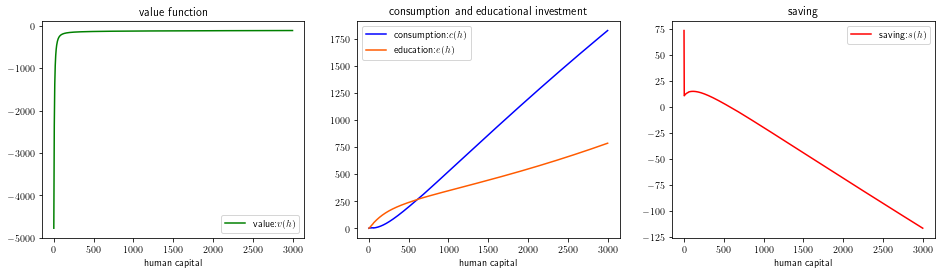

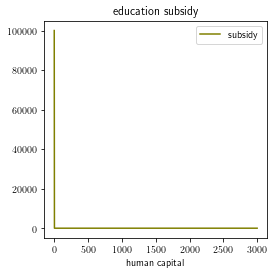

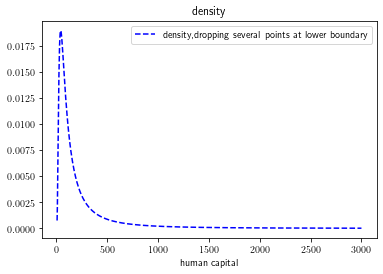

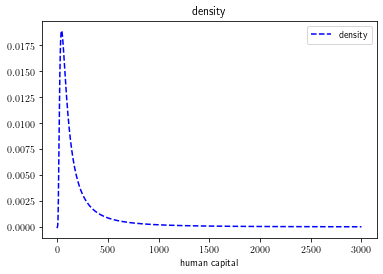

In [56]:
world0.plot_policy()

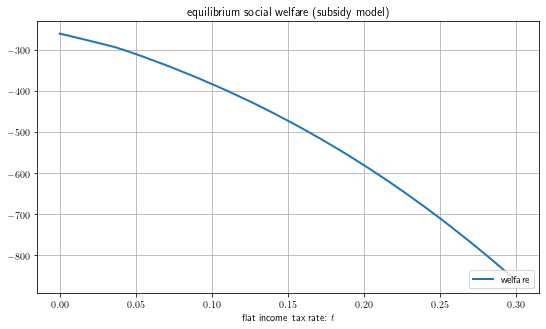

In [59]:
plt.figure(1,figsize=(9, 5))
plt.plot(tau_list[0:tau_size],posi_W_balanced[0,:],lw=2,label="welfare")  
plt.title('equilibrium social welfare (subsidy model)')
plt.grid()
plt.xlabel('flat income tax rate: $t$')
plt.legend(loc='lower right')
plt.show()

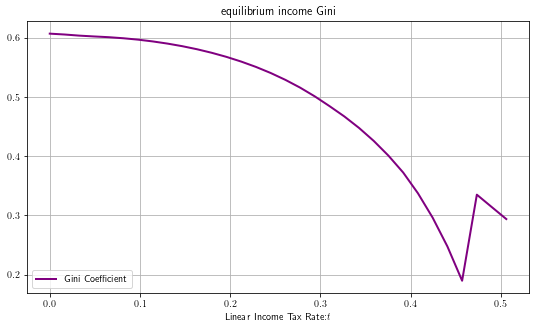

In [133]:
plt.figure(1,figsize=(9, 5))
plt.plot(tau_list[0:tau_size-2],Gini_balanced[0,:-2],lw=2,color = 'purple',label="Gini Coefficient")  
plt.title('equilibrium income Gini')
plt.grid()
plt.xlabel('Linear Income Tax Rate:$t$')
plt.legend(loc='lower left')
plt.show()